In [2]:
from sklearn.model_selection import train_test_split
import os
import shutil

def split_data(main_folder, train_folder, test_folder, test_size=0.2):
    # Create train and test directories if they don't exist
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    # Get the list of all subdirectories in the main folder
    subdirectories = [f.path for f in os.scandir(main_folder) if f.is_dir()]

    for subdirectory in subdirectories:
        class_name = os.path.basename(subdirectory)
        train_class_folder = os.path.join(train_folder, class_name)
        test_class_folder = os.path.join(test_folder, class_name)

        # Create train and test class directories if they don't exist
        os.makedirs(train_class_folder, exist_ok=True)
        os.makedirs(test_class_folder, exist_ok=True)

        # Get the list of files in the class folder
        files = os.listdir(subdirectory)

        # Split the files into train and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Move the files to the train folder
        for file in train_files:
            shutil.copy(os.path.join(subdirectory, file), train_class_folder)

        # Move the files to the test folder
        for file in test_files:
            shutil.copy(os.path.join(subdirectory, file), test_class_folder)

# Specify the paths for your main, train, and test folders
main_folder = '/kaggle/input/skin-dataset-last-version/data_10_classes_last_version'
train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

# Split the data
split_data(main_folder, train_folder, test_folder, test_size=0.2)

In [3]:
from keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
import numpy as np

def load_data(train_path, test_path, img_size=(224, 224), validation_split=0.2):
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset='validation')

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

def create_model(input_shape=(224, 224, 3), num_classes=10):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)  # Additional dense layer
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model

def compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

    # Printing training, validation, and testing accuracies
    train_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Training Accuracy:", np.mean(train_accuracy)*100)
    print("Validation Accuracy:", np.mean(validation_accuracy)*100)
    print("Testing Accuracy:", test_accuracy*100)

    return history


model_path='/kaggle/working/model.h5'
save_model_path = os.path.join(model_path, 'model.h5')

def save_model(model,save_model_path ):
    model.save(save_model_path)
def load_model( save_model_path):
    model = load_model(model_path)
    return model

# Main function to run the model
def run_model(train_path, test_path, learning_rate=0.001, epochs=10, save_model_path=None):
    train_generator, validation_generator, test_generator = load_data(train_path, test_path)
    num_classes = len(train_generator.class_indices)
    model = create_model(num_classes=num_classes)
    history = compile_and_train(model, train_generator, validation_generator, test_generator, learning_rate, epochs)

    if save_model_path:
        save_model(model, save_model_path)

    return history

# Example usage for training
train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'
save_model_path =  save_model_path
history = run_model(train_path, test_path, learning_rate=0.001, epochs=10, save_model_path=save_model_path)



Found 16488 images belonging to 10 classes.
Found 4115 images belonging to 10 classes.
Found 5154 images belonging to 10 classes.
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  4/516 ━━━━━━━━━━━━━━━━━━━━ 27s 53ms/step - accuracy: 0.2461 - loss: 2.2022 

I0000 00:00:1710625643.840903     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710625643.863322     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/516 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.6151 - loss: 1.1487

W0000 00:00:1710625652.485127     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7513 - loss: 0.7171

W0000 00:00:1710625678.682922     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.7514 - loss: 0.7167 - val_accuracy: 0.7120 - val_loss: 1.0697
Epoch 2/10


W0000 00:00:1710625692.561827     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9052 - loss: 0.2796 - val_accuracy: 0.7162 - val_loss: 1.1165
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.9378 - loss: 0.1850 - val_accuracy: 0.7281 - val_loss: 1.2299
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9586 - loss: 0.1219 - val_accuracy: 0.7575 - val_loss: 1.2076
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9759 - loss: 0.0773 - val_accuracy: 0.7361 - val_loss: 1.4112
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9841 - loss: 0.0537 - val_accuracy: 0.7162 - val_loss: 1.7615
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9905 - loss: 0.0370 - val_accuracy: 0.6945 - val_loss: 1.7802
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9890 - loss: 0.0362 - val_accuracy: 0.7312 - val_loss: 1.8343
Epoch 9/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9887 - loss: 0.0367 - val_accurac

W0000 00:00:1710626080.187029     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [4]:
from keras.models import load_model as keras_load_model

def load_model(save_model_path):
    model = keras_load_model(save_model_path)
    return model

loaded_model = load_model(save_model_path)

In [5]:
treatments =[["Acretin","Panthophil","Fucidin"]
             ,["Go to Doctor to upplay freezing by liquid Nitrogen"],
 ["Eucerin","Aveeno","Cetaphil","Dermalex","Honest","Grahams"]
             ,["Zovirax","Acyclovir","Cutacort"]
             ,["Terrasil","Mupiracin","Mupirax"],
  ["Conzerol","Zymaderm","Cooling or scraping (under the supervision of a doctor)"],
   ["Mostraizers","Betaderm","Betnovate"],
  ["Dermalex","Lapsorin","E45"],
   ["URLAGE","Aveeno","A-DERMA","Skinoren"],
    ["Roycederm","Terrasil","Betaclotry","Dermatin","Dr.Derm(TINEA)"],
      ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


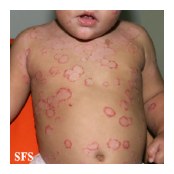

Treatments :
Terrasil
Mupiracin
Mupirax

Predicted Class: Impetigo
Actual Class: Impetigo
Confidence: 0.99751735


In [10]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def test_model(model, test_image_path, class_labels):
    img = image.load_img(test_image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    # Display the image
    plt.figure(figsize=(3, 2))  # Adjust the size as desired
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    treat=[]
    if  predicted_class=="Acne":
              treat=treatments [0]
    elif  predicted_class=="actinic keratosis":
      treat=treatments [1]
    elif  predicted_class=="Eczemaa":
      treat=treatments [2]
    elif  predicted_class=="Herpes Simplex":
      treat=treatments [3]
    elif  predicted_class=="Impetigo":
      treat=treatments [4]
    elif  predicted_class=="Molluscum Contagiosum":
      treat=treatments [5]
    elif  predicted_class=="Pityriasis Rosea":
      treat=treatments [6]
    elif  predicted_class=="Psoriasis":
      treat=treatments [7]
    elif  predicted_class=="Rosacea":
      treat=treatments [8]
    elif  predicted_class=="Tinea Corporis":
      treat=treatments [9]
    treats = '\n'.join(treat)
    print("Treatments :" )
    print(treats)
    print()
    print("Predicted Class:", predicted_class)
    print("Actual Class:", test_image_path.split("/")[-2])
    print("Confidence:", confidence)

# Load the trained model
#loaded_model = load_model('/content/drive/MyDrive/model.h5')

# Define the class labels
class_labels = ['Acne',
 'Eczemaa',
 'Herpes Simplex',
 'Impetigo',
 'Molluscum Contagiosum',
 'Pityriasis Rosea',
 'Psoriasis',
 'Rosacea',
 'Tinea Corporis',
 'actinic keratosis']

# Example usage for testing
test_image_path = '/kaggle/working/test/Impetigo/2799.jpg'
test_model(loaded_model, test_image_path, class_labels)